<a href="https://colab.research.google.com/github/Nicogameps5/Practica-red-convolutiva-FSI/blob/main/Pr%C3%A1ctica_red_convolutiva_FSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'sign-language-detection-dataset-5-classes' dataset.
Path del dataset descargado: /kaggle/input/sign-language-detection-dataset-5-classes

--- Estructura del dataset ---
/kaggle/input/sign-language-detection-dataset-5-classes/Sign Language Detection/dataset_split -> ['labels', 'images']

Clases detectadas: ['Yes', 'No', 'I Love You', 'Hello', 'Thank You']
Total de imágenes cargadas: 125

Imágenes totales: 125
Entrenamiento: 87
Validación: 38
Clases: ['Yes', 'No', 'I Love You', 'Hello', 'Thank You']


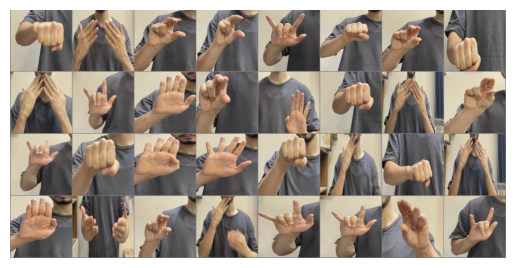

Etiquetas: Yes | Thank You | No | No | Hello | Yes | No | Yes | Thank You | Hello | I Love You | No | I Love You | Yes | Thank You | No | Hello | Yes | I Love You | I Love You | Yes | Thank You | Yes | Thank You | I Love You | Thank You | No | Thank You | Hello | Hello | No | Hello

--- Dimensiones ---
Tamaño de una imagen: torch.Size([3, 224, 224])
Dimensión del batch de imágenes: torch.Size([32, 3, 224, 224])
Dimensión del batch de etiquetas: torch.Size([32])


In [ ]:
# Instalaciones y librerías
import kagglehub
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Descargar dataset desde KaggleHub
path = kagglehub.dataset_download("mhmd1424/sign-language-detection-dataset-5-classes")
print("Path del dataset descargado:", path)

# Rutas principales
base_dir = os.path.join(path, "Sign Language Detection", "dataset_split")
img_dir = os.path.join(base_dir, "images")
label_dir = os.path.join(base_dir, "labels")

# Verificar estructura
print("\n--- Estructura del dataset ---")
for root, dirs, files in os.walk(base_dir):
    print(root, "->", dirs[:5])
    if "images" in dirs:
        break

# Clases del dataset
classes = ['Yes', 'No', 'I Love You', 'Hello', 'Thank You']
print("\nClases detectadas:", classes)

# Semilla para reproducibilidad
def seed_everything(seed):
    import random, os
    import numpy as np
    import torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

# Transformaciones (con data argumentation)
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# Dataset personalizado (clasificación basada en etiquetas YOLO)
class SignLanguageDataset(Dataset):
    def __init__(self, img_path, lbl_path, transform=None):
        self.img_path = img_path
        self.lbl_path = lbl_path
        self.transform = transform
        self.samples = []

        # Recorremos todas las imágenes
        for split in ["train", "val", "test"]:
            img_split_dir = os.path.join(img_path, split)
            lbl_split_dir = os.path.join(lbl_path, split)

            if not os.path.exists(img_split_dir):
                continue

            for img_name in os.listdir(img_split_dir):
                if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    img_file = os.path.join(img_split_dir, img_name)
                    lbl_file = os.path.join(lbl_split_dir, os.path.splitext(img_name)[0] + ".txt")

                    # Leer el archivo de etiqueta YOLO (primera línea, primer valor = class_id)
                    if os.path.exists(lbl_file):
                        with open(lbl_file, "r") as f:
                            line = f.readline().strip()
                            if line:
                                class_id = int(line.split()[0])
                                self.samples.append((img_file, class_id))

        print(f"Total de imágenes cargadas: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_file, class_id = self.samples[idx]
        image = Image.open(img_file).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_id


# Crear dataset
dataset = SignLanguageDataset(img_dir, label_dir, transform=None)

# Dividir en entrenamiento y validación
train_ratio = 0.7
val_ratio = 0.3

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size

train_set, val_set = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Aplicar transformaciones
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_test_transform

# Dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# Mostrar información
print(f"\nImágenes totales: {len(dataset)}")
print(f"Entrenamiento: {len(train_set)}")
print(f"Validación: {len(val_set)}")
print(f"Clases: {classes}")

# Función para mostrar imágenes
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Mostrar un batch de imágenes
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Etiquetas:', ' | '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

# Verificar dimensiones
print("\n--- Dimensiones ---")
print(f"Tamaño de una imagen: {train_set[0][0].shape}")
print(f"Dimensión del batch de imágenes: {images.shape}")
print(f"Dimensión del batch de etiquetas: {labels.shape}")

In [ ]:
# Función de entrenamiento
def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs, device):
    history = {
        "train_losses": [],
        "val_losses": [],
        "train_acc": [],
        "val_acc": []
    }

    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        # Entrenamiento
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        train_acc = 100 * correct_train / total_train

        # Validación
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_acc = 100 * correct_val / total_val

        # Guardar en history
        history["train_losses"].append(running_loss / len(train_loader))
        history["val_losses"].append(val_loss / len(dev_loader))
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # Mostrar la evolución
        print(f"  Época [{epoch+1}/{epochs}] "
              f"- Loss train: {history['train_losses'][-1]:.4f} | "
              f"Loss val: {history['val_losses'][-1]:.4f} | "
              f"Acc train: {train_acc:.2f}% | "
              f"Acc val: {val_acc:.2f}%")

    return model, history

  Época [1/20] - Loss train: 2.0811 | Loss val: 1.6374 | Acc train: 31.03% | Acc val: 34.21%
  Época [2/20] - Loss train: 1.4742 | Loss val: 1.6217 | Acc train: 70.11% | Acc val: 34.21%
  Época [3/20] - Loss train: 0.8870 | Loss val: 1.7700 | Acc train: 68.97% | Acc val: 34.21%
  Época [4/20] - Loss train: 0.3198 | Loss val: 1.8417 | Acc train: 85.06% | Acc val: 21.05%
  Época [5/20] - Loss train: 0.2396 | Loss val: 2.0053 | Acc train: 93.10% | Acc val: 31.58%
  Época [6/20] - Loss train: 0.1855 | Loss val: 2.1010 | Acc train: 95.40% | Acc val: 47.37%
  Época [7/20] - Loss train: 0.0411 | Loss val: 2.2237 | Acc train: 98.85% | Acc val: 47.37%
  Época [8/20] - Loss train: 0.0594 | Loss val: 2.1818 | Acc train: 97.70% | Acc val: 44.74%
  Época [9/20] - Loss train: 0.0361 | Loss val: 1.8676 | Acc train: 100.00% | Acc val: 52.63%
  Época [10/20] - Loss train: 0.0147 | Loss val: 1.5471 | Acc train: 100.00% | Acc val: 50.00%
  Época [11/20] - Loss train: 0.0225 | Loss val: 1.2962 | Acc train

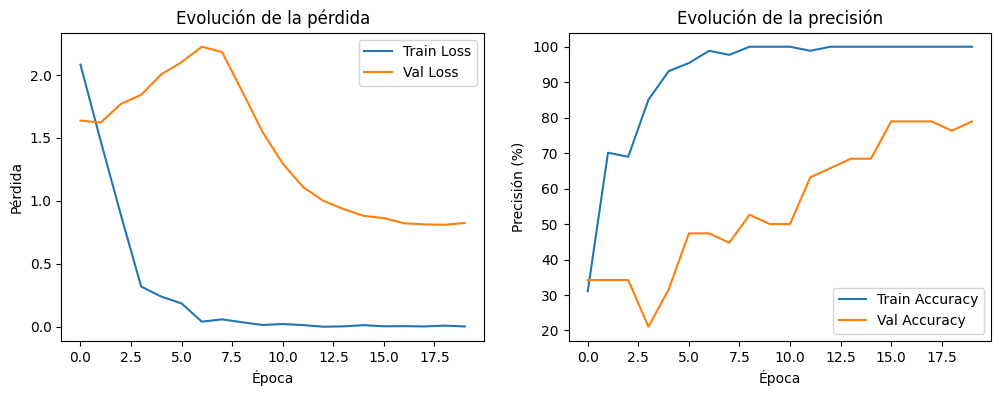

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Modelo CNN
class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SignLanguageCNN, self).__init__()

        # Bloque 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Bloque 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Bloque 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Capa totalmente conectada
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Bloque 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # Bloque 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # Bloque 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        # Aplanar
        x = x.view(x.size(0), -1)
        # FC
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Ejemplo inicial sin transfer learning

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SignLanguageCNN(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

EPOCHS = 20

seed_everything(SEED)

model_trained, history = train_with_validation(
    model=model,
    train_loader=train_loader,
    dev_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device
)

print("✅ Entrenamiento completado.")

# Gráficas de pérdida y precisión
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history["train_losses"], label="Train Loss")
plt.plot(history["val_losses"], label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.title("Evolución de la pérdida")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.legend()
plt.title("Evolución de la precisión")

plt.show()



  Precisión final en VALIDACIÓN: 78.95%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       0.80      0.50      0.62         8
          No       0.71      0.83      0.77        12
  I Love You       0.80      1.00      0.89         4
       Hello       0.71      0.71      0.71         7
   Thank You       1.00      1.00      1.00         7

    accuracy                           0.79        38
   macro avg       0.81      0.81      0.80        38
weighted avg       0.79      0.79      0.78        38



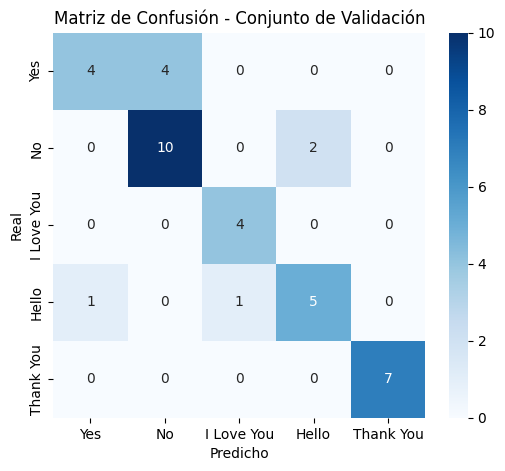

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión usando validación

def Matriz_en_validacion(model, val_loader, classes, device):

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy final
    val_acc_final = 100 * (sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels))
    print(f"\n  Precisión final en VALIDACIÓN: {val_acc_final:.2f}%")

    # Informe de clasificación
    print("\n--- Informe de clasificación (Validación) ---")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión - Conjunto de Validación')
    plt.show()

    return val_acc_final, cm


val_acc_tl, cm_tl = Matriz_en_validacion(
    model=model,
    val_loader=val_loader,
    classes=classes,
    device=device
)


  Aplicando TRANSFER LEARNING con ResNet18...

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


  Época [1/20] - Loss train: 1.8149 | Loss val: 1.7466 | Acc train: 11.49% | Acc val: 7.89%
  Época [2/20] - Loss train: 1.5652 | Loss val: 1.6106 | Acc train: 19.54% | Acc val: 10.53%
  Época [3/20] - Loss train: 1.3563 | Loss val: 1.3441 | Acc train: 42.53% | Acc val: 44.74%
  Época [4/20] - Loss train: 1.1879 | Loss val: 1.1069 | Acc train: 70.11% | Acc val: 65.79%
  Época [5/20] - Loss train: 1.0359 | Loss val: 0.9801 | Acc train: 87.36% | Acc val: 84.21%
  Época [6/20] - Loss train: 0.9035 | Loss val: 0.8757 | Acc train: 89.66% | Acc val: 89.47%
  Época [7/20] - Loss train: 0.7733 | Loss val: 0.7911 | Acc train: 94.25% | Acc val: 94.74%
  Época [8/20] - Loss train: 0.6921 | Loss val: 0.7277 | Acc train: 91.95% | Acc val: 92.11%
  Época [9/20] - Loss train: 0.6004 | Loss val: 0.6887 | Acc train: 97.70% | Acc val: 84.21%
  Época [10/20] - Loss train: 0.5174 | Loss val: 0.6107 | Acc train: 97.70% | Acc val: 94.74%
  Época [11/20] - Loss train: 0.4835 | Loss val: 0.5552 | Acc train: 9

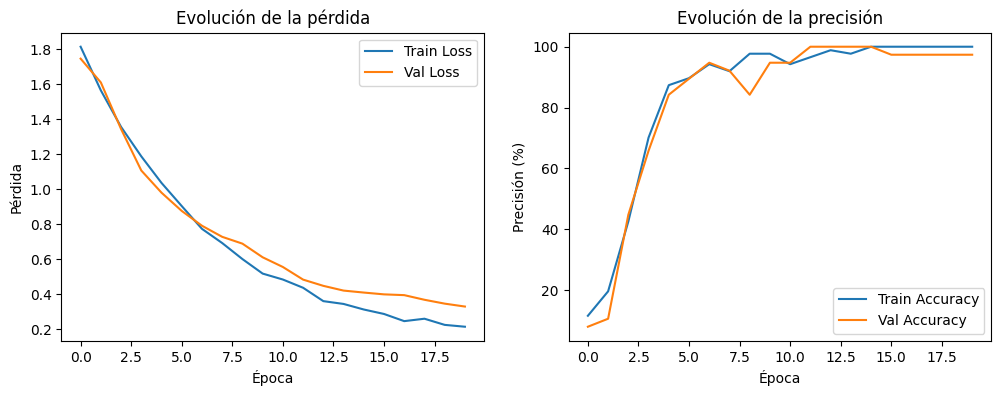


  Precisión final en VALIDACIÓN: 97.37%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       1.00      1.00      1.00         8
          No       1.00      1.00      1.00        12
  I Love You       1.00      1.00      1.00         4
       Hello       1.00      0.86      0.92         7
   Thank You       0.88      1.00      0.93         7

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



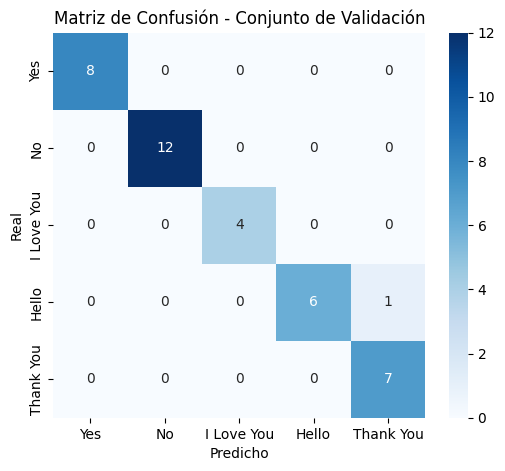

In [ ]:
# TRANSFER LEARNING
print("\n  Aplicando TRANSFER LEARNING con ResNet18...\n")

import torchvision.models as models

seed_everything(SEED)

# Cargar modelo preentrenado
transfer_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar parámetros
for param in transfer_model.parameters():
    param.requires_grad = False

# Reemplazar la última capa (fc) por una nueva con 5 clases
transfer_model.fc = nn.Linear(512, len(classes))

# Enviar a GPU/CPU
transfer_model = transfer_model.to(device)

# Definir loss y optimizador (solo entrena la nueva cabeza)
criterion_tl = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(transfer_model.fc.parameters(), lr=0.001)


tl_model, tl_history = train_with_validation(
    model=transfer_model,
    train_loader=train_loader,
    dev_loader=val_loader,
    criterion=criterion_tl,
    optimizer=optimizer_tl,
    epochs=20,
    device=device
)


print("\n✅ Transfer Learning completado correctamente.\n")

# Gráficas de pérdida y precisión
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tl_history["train_losses"], label="Train Loss")
plt.plot(tl_history["val_losses"], label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.title("Evolución de la pérdida")

plt.subplot(1,2,2)
plt.plot(tl_history["train_acc"], label="Train Accuracy")
plt.plot(tl_history["val_acc"], label="Val Accuracy")
plt.xlabel("Época")
plt.ylabel("Precisión (%)")
plt.legend()
plt.title("Evolución de la precisión")

plt.show()


val_acc_tl, cm_tl = Matriz_en_validacion(
    model=transfer_model,
    val_loader=val_loader,
    classes=classes,
    device=device
)


--- Entrenando modelo: 2bloques ---
  Época [1/20] - Loss train: 4.0618 | Loss val: 1.9093 | Acc train: 28.74% | Acc val: 44.74%
  Época [2/20] - Loss train: 3.5796 | Loss val: 1.3913 | Acc train: 44.83% | Acc val: 31.58%
  Época [3/20] - Loss train: 1.4663 | Loss val: 1.2062 | Acc train: 68.97% | Acc val: 50.00%
  Época [4/20] - Loss train: 1.2324 | Loss val: 1.2151 | Acc train: 70.11% | Acc val: 57.89%
  Época [5/20] - Loss train: 0.3079 | Loss val: 1.2651 | Acc train: 88.51% | Acc val: 55.26%
  Época [6/20] - Loss train: 0.2986 | Loss val: 1.1832 | Acc train: 89.66% | Acc val: 65.79%
  Época [7/20] - Loss train: 0.1443 | Loss val: 1.1891 | Acc train: 95.40% | Acc val: 68.42%
  Época [8/20] - Loss train: 0.1852 | Loss val: 1.1623 | Acc train: 94.25% | Acc val: 71.05%
  Época [9/20] - Loss train: 0.0521 | Loss val: 1.1322 | Acc train: 97.70% | Acc val: 73.68%
  Época [10/20] - Loss train: 0.0279 | Loss val: 1.1060 | Acc train: 98.85% | Acc val: 73.68%
  Época [11/20] - Loss train: 0.

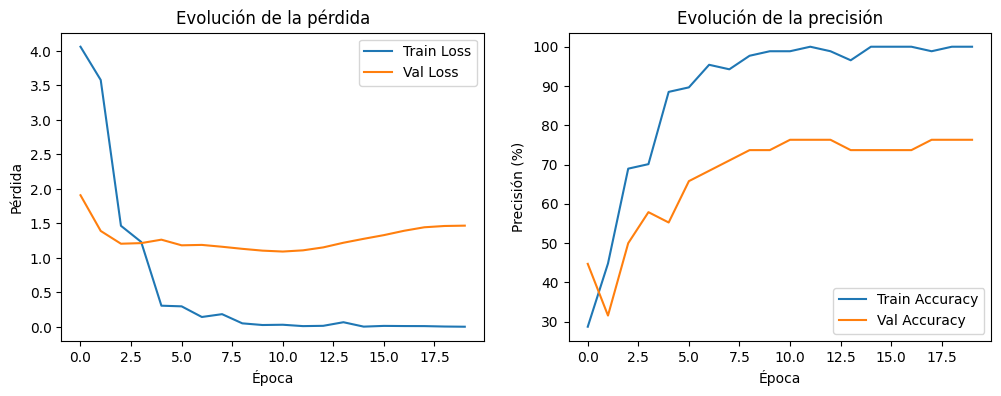


  Precisión final en VALIDACIÓN: 76.32%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       0.71      0.62      0.67         8
          No       0.89      0.67      0.76        12
  I Love You       0.50      1.00      0.67         4
       Hello       0.83      0.71      0.77         7
   Thank You       0.88      1.00      0.93         7

    accuracy                           0.76        38
   macro avg       0.76      0.80      0.76        38
weighted avg       0.80      0.76      0.76        38



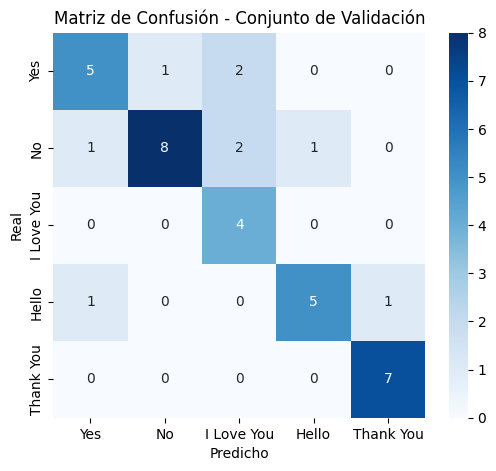

Resultado 2bloques: best_val_acc = 76.32%, tiempo = 112s

--- Entrenando modelo: 3bloques ---
  Época [1/20] - Loss train: 3.5500 | Loss val: 1.5502 | Acc train: 24.14% | Acc val: 26.32%
  Época [2/20] - Loss train: 3.0661 | Loss val: 1.5471 | Acc train: 48.28% | Acc val: 26.32%
  Época [3/20] - Loss train: 0.8247 | Loss val: 1.7831 | Acc train: 75.86% | Acc val: 23.68%
  Época [4/20] - Loss train: 0.7162 | Loss val: 2.0591 | Acc train: 80.46% | Acc val: 31.58%
  Época [5/20] - Loss train: 0.6768 | Loss val: 1.8774 | Acc train: 80.46% | Acc val: 23.68%
  Época [6/20] - Loss train: 0.3176 | Loss val: 1.6950 | Acc train: 91.95% | Acc val: 31.58%
  Época [7/20] - Loss train: 0.2296 | Loss val: 1.8728 | Acc train: 91.95% | Acc val: 28.95%
  Época [8/20] - Loss train: 0.0219 | Loss val: 2.0242 | Acc train: 100.00% | Acc val: 31.58%
  Época [9/20] - Loss train: 0.0223 | Loss val: 2.0322 | Acc train: 100.00% | Acc val: 36.84%
  Época [10/20] - Loss train: 0.0568 | Loss val: 1.8317 | Acc train

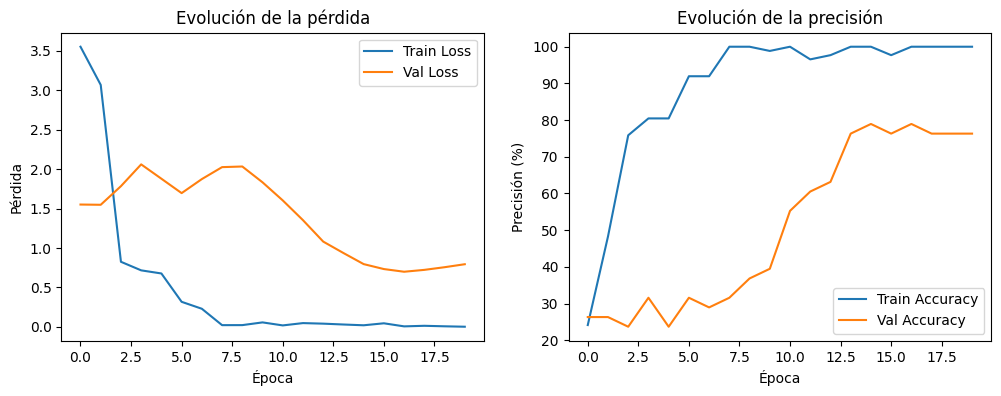


  Precisión final en VALIDACIÓN: 76.32%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       0.86      0.75      0.80         8
          No       0.88      0.58      0.70        12
  I Love You       0.57      1.00      0.73         4
       Hello       0.56      0.71      0.62         7
   Thank You       1.00      1.00      1.00         7

    accuracy                           0.76        38
   macro avg       0.77      0.81      0.77        38
weighted avg       0.80      0.76      0.77        38



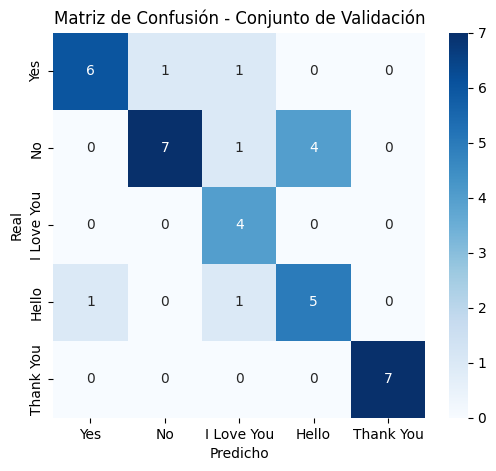

Resultado 3bloques: best_val_acc = 78.95%, tiempo = 112s

--- Entrenando modelo: 4bloques ---
  Época [1/20] - Loss train: 1.6008 | Loss val: 1.6246 | Acc train: 27.59% | Acc val: 21.05%
  Época [2/20] - Loss train: 0.9281 | Loss val: 1.6691 | Acc train: 72.41% | Acc val: 21.05%
  Época [3/20] - Loss train: 0.4728 | Loss val: 1.7160 | Acc train: 86.21% | Acc val: 31.58%
  Época [4/20] - Loss train: 0.2677 | Loss val: 1.7741 | Acc train: 90.80% | Acc val: 21.05%
  Época [5/20] - Loss train: 0.2505 | Loss val: 1.8452 | Acc train: 89.66% | Acc val: 21.05%
  Época [6/20] - Loss train: 0.1604 | Loss val: 1.8904 | Acc train: 96.55% | Acc val: 23.68%
  Época [7/20] - Loss train: 0.0964 | Loss val: 1.8796 | Acc train: 96.55% | Acc val: 52.63%
  Época [8/20] - Loss train: 0.1011 | Loss val: 1.7703 | Acc train: 98.85% | Acc val: 57.89%
  Época [9/20] - Loss train: 0.0785 | Loss val: 1.5553 | Acc train: 97.70% | Acc val: 52.63%
  Época [10/20] - Loss train: 0.0272 | Loss val: 1.3254 | Acc train: 

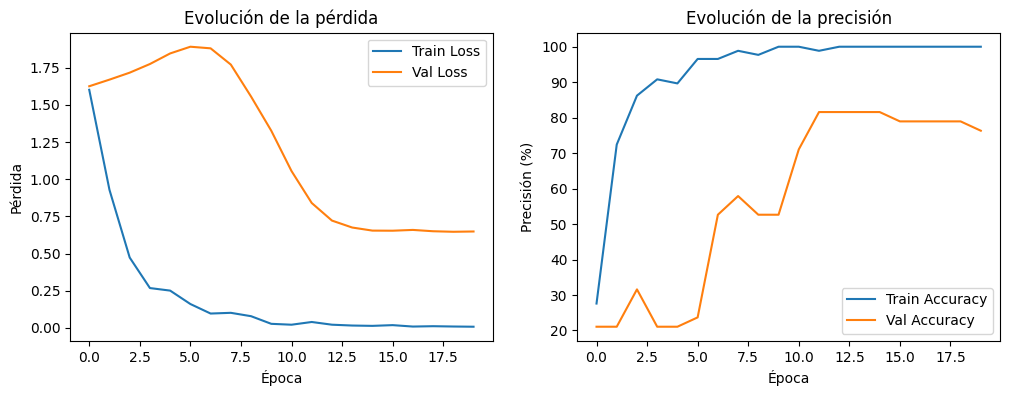


  Precisión final en VALIDACIÓN: 76.32%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       0.86      0.75      0.80         8
          No       0.88      0.58      0.70        12
  I Love You       0.67      1.00      0.80         4
       Hello       0.56      0.71      0.62         7
   Thank You       0.88      1.00      0.93         7

    accuracy                           0.76        38
   macro avg       0.77      0.81      0.77        38
weighted avg       0.79      0.76      0.76        38



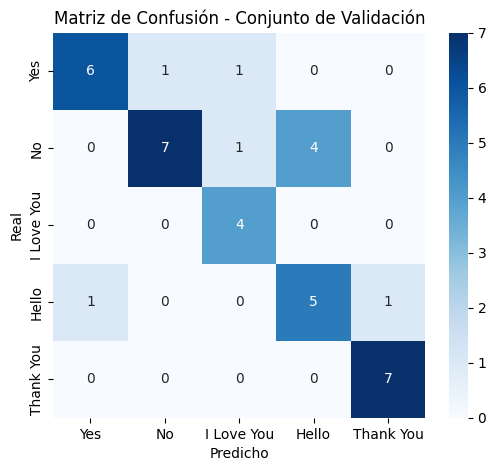

Resultado 4bloques: best_val_acc = 81.58%, tiempo = 107s

=== RESUMEN FINAL (comparación simple) ===
2bloques -> ValAcc: 76.32% | Loss final: 1.4682 | Tiempo(s): 112
3bloques -> ValAcc: 78.95% | Loss final: 0.7939 | Tiempo(s): 112
4bloques -> ValAcc: 81.58% | Loss final: 0.6481 | Tiempo(s): 107

Conclusión breve:
- El mejor modelo fue 4bloques con 81.58% de validación.
- El peor modelo fue 2bloques con 76.32%.
- Observación: si el modelo más profundo no mejora mucho, quedarse con el más simple para ahorrar tiempo.


In [ ]:
# Comparar 3 modelos diferentes con los mismos hiperparámetros.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time

# Configuración base
LR = 0.0001
BATCH_SIZE = 32
DROPOUT = 0.5
OPTIM = "adamw"
EPOCHS_SIMPLE = 20

# Asegurar que la semilla global ya esté fijada
try:
    SEED
except NameError:
    SEED = 42
    seed_everything(SEED)

# Definir tres modelos sencillos
class Modelo2Bloques(nn.Module):
    # Modelo con 2 bloques conv + 1 FC
    def __init__(self, num_classes=5, dropout=DROPOUT):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)

        # entrada 224x224 => tras 2 pools: 56x56
        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

class Modelo3Bloques(nn.Module):
    # Modelo con 3 bloques conv + 1 FC
    def __init__(self, num_classes=5, dropout=DROPOUT):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2,2)

        # tras 3 pools: 28x28
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

class Modelo4Bloques(nn.Module):
    # Modelo con 4 bloques conv (más profundo)
    def __init__(self, num_classes=5, dropout=DROPOUT):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2,2)

        # tras 4 pools: 14x14
        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


# Función auxiliar mínima para crear optimizador
def make_optimizer(model, name="adamw", lr=LR):
    if name.lower() == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return torch.optim.AdamW(model.parameters(), lr=lr)

# Lista de modelos
model_builders = [
    ("2bloques", Modelo2Bloques),
    ("3bloques", Modelo3Bloques),
    ("4bloques", Modelo4Bloques),
]

results_simple = []

# Entrenar cada modelo con los mismos hiperparámetros
for name, Builder in model_builders:
    print("\n--- Entrenando modelo:", name, "---")
    # Creo el modelo nuevo
    model = Builder(num_classes=len(classes), dropout=DROPOUT).to(device)

    # Optimizador
    optimizer = make_optimizer(model, name=OPTIM, lr=LR)

    # DataLoaders con la misma batch size
    train_loader_exp = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_exp   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Entrenar usando la función
    t0 = time.time()
    trained, history = train_with_validation(
        model=model,
        train_loader=train_loader_exp,
        dev_loader=val_loader_exp,
        criterion=criterion,
        optimizer=optimizer,
        epochs=EPOCHS_SIMPLE,
        device=device
    )
    t_elapsed = int(time.time() - t0)

    # Gráficas de pérdida y precisión
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history["train_losses"], label="Train Loss")
    plt.plot(history["val_losses"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.title("Evolución de la pérdida")

    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Val Accuracy")
    plt.xlabel("Época")
    plt.ylabel("Precisión (%)")
    plt.legend()
    plt.title("Evolución de la precisión")

    plt.show()


    val_acc_tl, cm_tl = Matriz_en_validacion(
        model=model,
        val_loader=val_loader_exp,
        classes=classes,
        device=device
    )

    best_val = max(history["val_acc"]) if len(history["val_acc"])>0 else None
    final_val_loss = history["val_losses"][-1] if len(history["val_losses"])>0 else None

    print(f"Resultado {name}: best_val_acc = {best_val:.2f}%, tiempo = {t_elapsed}s")

    # Guardar resultados
    results_simple.append({
        "model": name,
        "best_val_acc": best_val,
        "final_val_loss": final_val_loss,
        "time_s": t_elapsed
    })

# Imprimir resumen final simple
print("\n=== RESUMEN FINAL (comparación simple) ===")
for r in results_simple:
    print(f"{r['model']:8s} -> ValAcc: {r['best_val_acc']:.2f}% | Loss final: {r['final_val_loss']:.4f} | Tiempo(s): {r['time_s']}")

print("\nConclusión breve:")

# Saco la mejor y la peor de forma simple
best = max(results_simple, key=lambda x: x["best_val_acc"])
worst = min(results_simple, key=lambda x: x["best_val_acc"])
print(f"- El mejor modelo fue {best['model']} con {best['best_val_acc']:.2f}% de validación.")
print(f"- El peor modelo fue {worst['model']} con {worst['best_val_acc']:.2f}%.")
print("- Observación: si el modelo más profundo no mejora mucho, quedarse con el más simple para ahorrar tiempo.")



=== EXPERIMENTO 1 de 6 ===
lr=0.0001, batch=32, dropout=0.5, opt=adamw
🌀 Época [1/20] - Loss train: 2.1428 | Loss val: 1.5348 | Acc train: 29.89% | Acc val: 23.68%
🌀 Época [2/20] - Loss train: 1.9700 | Loss val: 1.5611 | Acc train: 50.57% | Acc val: 31.58%
🌀 Época [3/20] - Loss train: 0.8192 | Loss val: 1.8560 | Acc train: 72.41% | Acc val: 21.05%
🌀 Época [4/20] - Loss train: 0.4108 | Loss val: 1.8759 | Acc train: 85.06% | Acc val: 23.68%
🌀 Época [5/20] - Loss train: 0.1888 | Loss val: 1.9012 | Acc train: 91.95% | Acc val: 36.84%
🌀 Época [6/20] - Loss train: 0.2319 | Loss val: 1.8730 | Acc train: 93.10% | Acc val: 34.21%
🌀 Época [7/20] - Loss train: 0.0939 | Loss val: 1.7049 | Acc train: 94.25% | Acc val: 34.21%
🌀 Época [8/20] - Loss train: 0.1053 | Loss val: 1.5746 | Acc train: 95.40% | Acc val: 28.95%
🌀 Época [9/20] - Loss train: 0.0162 | Loss val: 1.4922 | Acc train: 100.00% | Acc val: 47.37%
🌀 Época [10/20] - Loss train: 0.0503 | Loss val: 1.3002 | Acc train: 98.85% | Acc val: 63.

,lr,batch_size,dropout,optimizer,best_val_acc,time_s
0,0.0001,32,0.5,adamw,89.473684,114.0
1,0.0005,32,0.5,adamw,86.842105,113.2
2,0.0007,32,0.6,adamw,86.842105,113.5
3,0.0010,32,0.5,adamw,81.578947,114.3
4,0.0001,32,0.0,adamw,71.052632,114.3
5,0.0001,64,0.5,adamw,68.421053,113.5



Media ValAcc por learning rate:
lr
0.0001    76.315789
0.0005    86.842105
0.0007    86.842105
0.0010    81.578947
Name: best_val_acc, dtype: float64

Media ValAcc por dropout:
dropout
0.0    71.052632
0.5    81.578947
0.6    86.842105
Name: best_val_acc, dtype: float64

Media ValAcc por batch_size:
batch_size
32    83.157895
64    68.421053
Name: best_val_acc, dtype: float64


--- Generando gráficas y matrices de confusión por experimento ---

>>> Resultado: exp_1_lr0.0001_bs32_drop0.5  - best_val_acc: 89.47368421052632


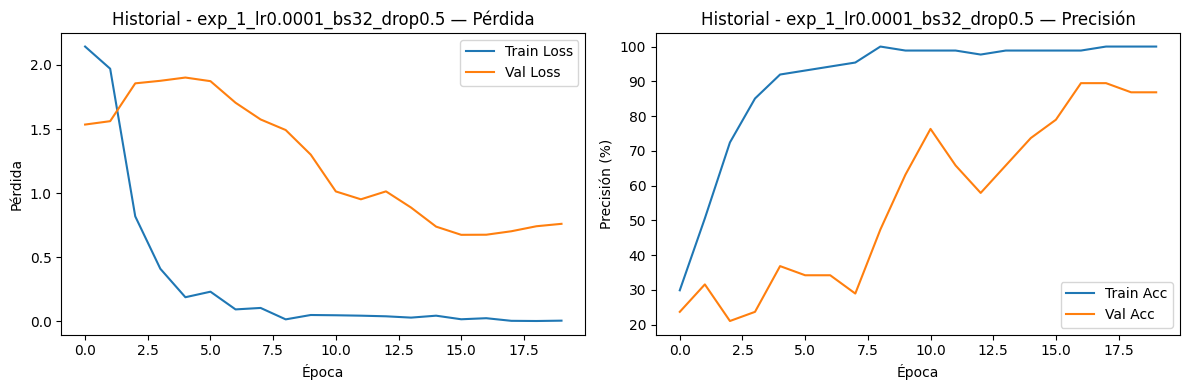


🎯 Precisión final en VALIDACIÓN: 86.84%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       1.00      0.75      0.86         8
          No       0.75      1.00      0.86        12
  I Love You       0.80      1.00      0.89         4
       Hello       1.00      0.71      0.83         7
   Thank You       1.00      0.86      0.92         7

    accuracy                           0.87        38
   macro avg       0.91      0.86      0.87        38
weighted avg       0.90      0.87      0.87        38



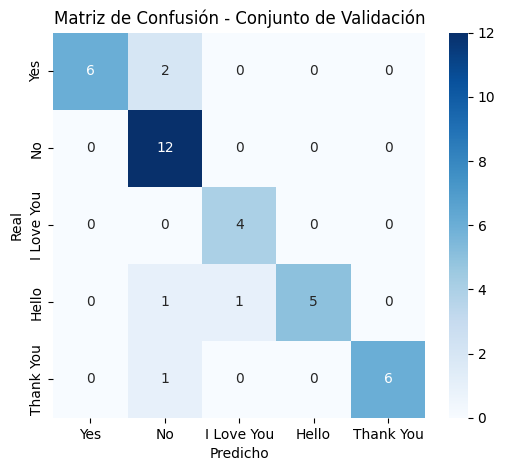


>>> Resultado: exp_2_lr0.0005_bs32_drop0.5  - best_val_acc: 86.84210526315789


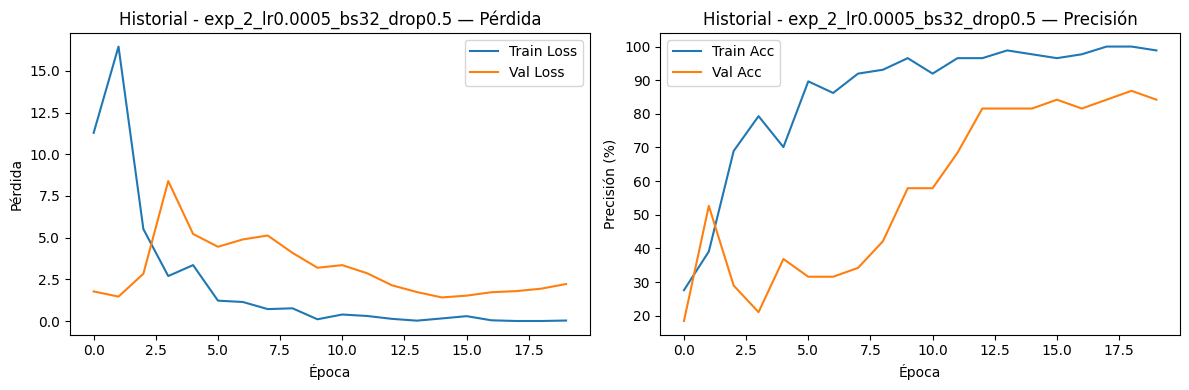


🎯 Precisión final en VALIDACIÓN: 84.21%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       0.78      0.88      0.82         8
          No       1.00      0.75      0.86        12
  I Love You       0.67      1.00      0.80         4
       Hello       0.83      0.71      0.77         7
   Thank You       0.88      1.00      0.93         7

    accuracy                           0.84        38
   macro avg       0.83      0.87      0.84        38
weighted avg       0.86      0.84      0.84        38



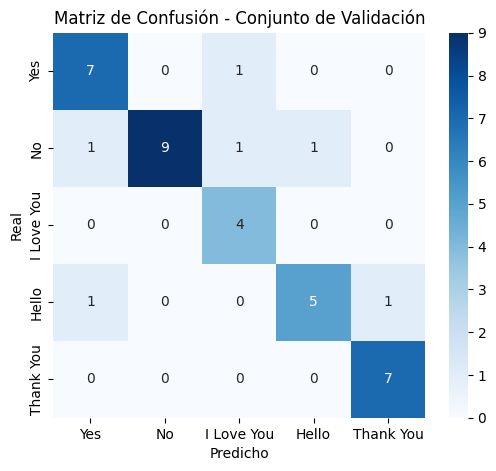


>>> Resultado: exp_3_lr0.001_bs32_drop0.5  - best_val_acc: 81.57894736842105


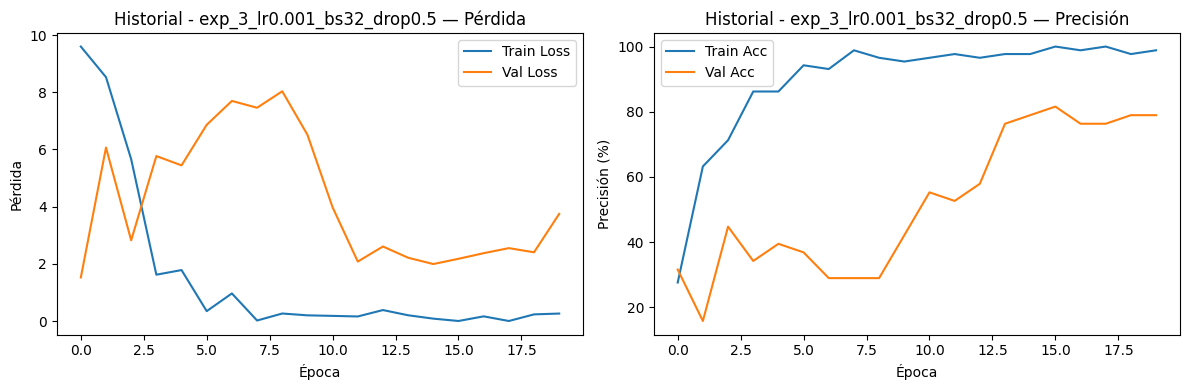


🎯 Precisión final en VALIDACIÓN: 78.95%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       1.00      0.38      0.55         8
          No       0.75      1.00      0.86        12
  I Love You       0.50      1.00      0.67         4
       Hello       1.00      0.71      0.83         7
   Thank You       1.00      0.86      0.92         7

    accuracy                           0.79        38
   macro avg       0.85      0.79      0.77        38
weighted avg       0.87      0.79      0.78        38



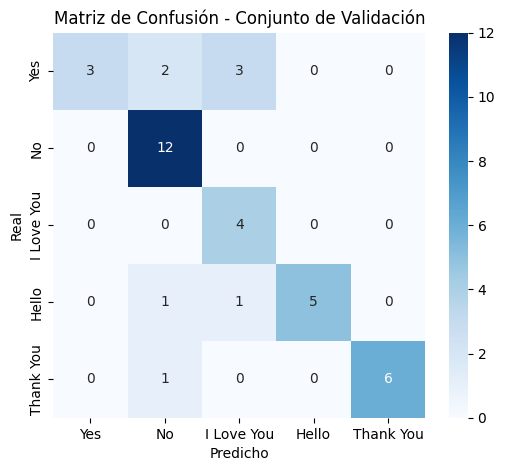


>>> Resultado: exp_4_lr0.0001_bs32_drop0.0  - best_val_acc: 71.05263157894737


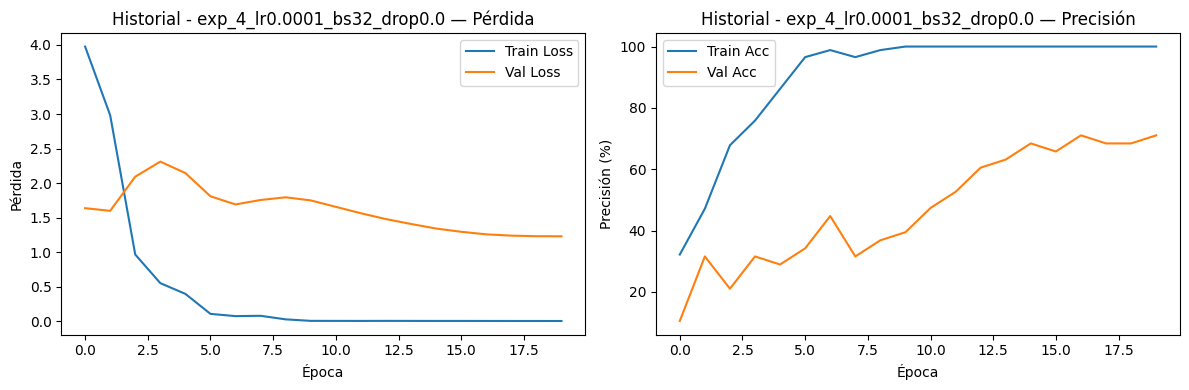


🎯 Precisión final en VALIDACIÓN: 71.05%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       0.80      0.50      0.62         8
          No       0.88      0.58      0.70        12
  I Love You       0.40      1.00      0.57         4
       Hello       0.62      0.71      0.67         7
   Thank You       1.00      1.00      1.00         7

    accuracy                           0.71        38
   macro avg       0.74      0.76      0.71        38
weighted avg       0.79      0.71      0.72        38



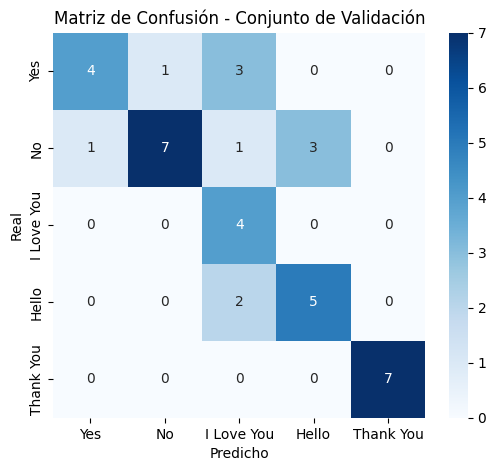


>>> Resultado: exp_5_lr0.0001_bs64_drop0.5  - best_val_acc: 68.42105263157895


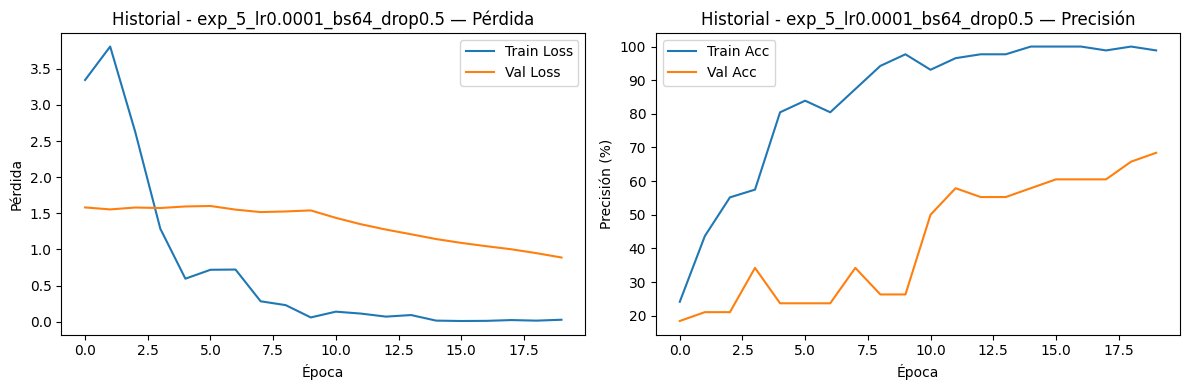


🎯 Precisión final en VALIDACIÓN: 68.42%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       0.80      0.50      0.62         8
          No       0.82      0.75      0.78        12
  I Love You       0.31      1.00      0.47         4
       Hello       1.00      0.57      0.73         7
   Thank You       1.00      0.71      0.83         7

    accuracy                           0.68        38
   macro avg       0.79      0.71      0.69        38
weighted avg       0.83      0.68      0.71        38



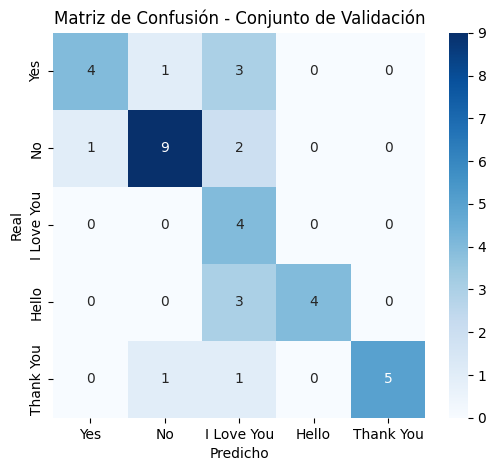


>>> Resultado: exp_6_lr0.0007_bs32_drop0.6  - best_val_acc: 86.84210526315789


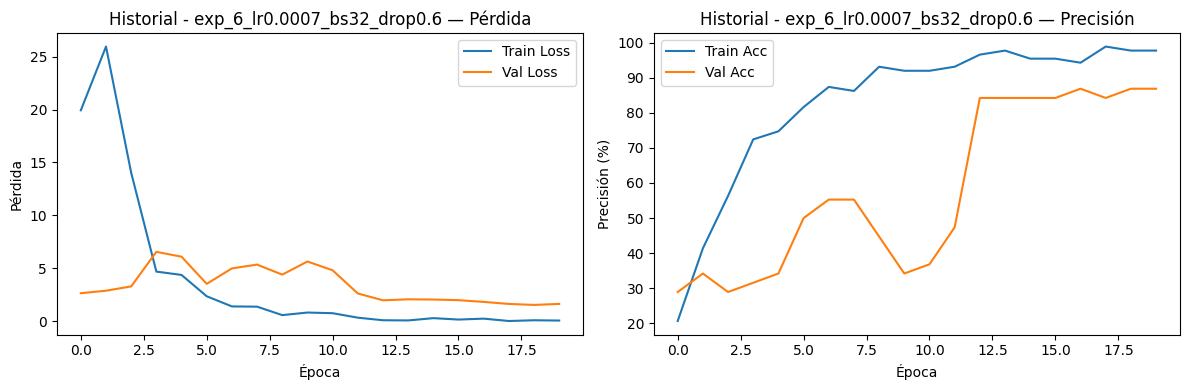


🎯 Precisión final en VALIDACIÓN: 86.84%

--- Informe de clasificación (Validación) ---
              precision    recall  f1-score   support

         Yes       0.86      0.75      0.80         8
          No       0.85      0.92      0.88        12
  I Love You       0.67      1.00      0.80         4
       Hello       1.00      0.71      0.83         7
   Thank You       1.00      1.00      1.00         7

    accuracy                           0.87        38
   macro avg       0.87      0.88      0.86        38
weighted avg       0.89      0.87      0.87        38



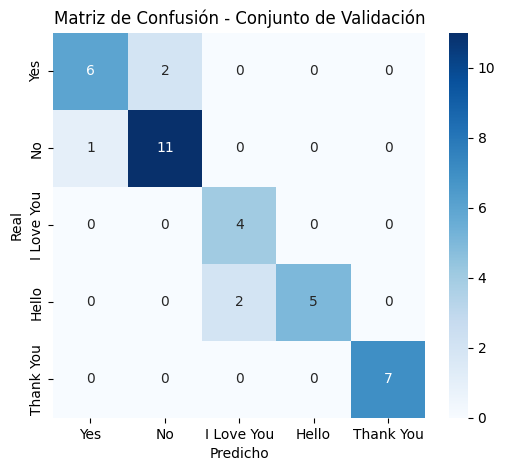


He generado todas las gráficas y matrices disponibles.


In [ ]:
# Probar con distintos hiperparámetros

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import pandas as pd

seed_everything(SEED)

# Definir las configuraciones.
configurations = [
    {"lr": 1e-4, "batch_size": 32, "dropout": 0.5, "optimizer": "adamw"},  # baseline
    {"lr": 5e-4, "batch_size": 32, "dropout": 0.5, "optimizer": "adamw"},  # lr un poco mayor
    {"lr": 1e-3, "batch_size": 32, "dropout": 0.5, "optimizer": "adamw"},  # lr alto
    {"lr": 1e-4, "batch_size": 32, "dropout": 0.0, "optimizer": "adamw"},  # sin dropout
    {"lr": 1e-4, "batch_size": 64, "dropout": 0.5, "optimizer": "adamw"},  # batch grande
    {"lr": 7e-4, "batch_size": 32, "dropout": 0.6, "optimizer": "adamw"},  # mix experimental
]

EPOCHS_EXP = 20

results = []
exp_i = 0
start_all = time.time()

# Funciones auxiliares para graficar
def plot_history(history, title=None):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_losses"], label="Train Loss")
    plt.plot(history["val_losses"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    if title:
        plt.title(title + " — Pérdida")

    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Época")
    plt.ylabel("Precisión (%)")
    plt.legend()
    if title:
        plt.title(title + " — Precisión")

    plt.tight_layout()
    plt.show()


# Bucle de experimentos
for cfg in configurations:
    exp_i += 1
    print("\n=== EXPERIMENTO", exp_i, "de", len(configurations), "===")
    print(f"lr={cfg['lr']}, batch={cfg['batch_size']}, dropout={cfg['dropout']}, opt={cfg['optimizer']}")

    # Fijar semilla por experimento para reproducibilidad
    seed_everything(SEED + exp_i)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Crear modelo
    model = SignLanguageCNN(num_classes=len(classes)).to(device)

    # Cambiar el dropout
    try:
        model.dropout.p = cfg["dropout"]
    except:
        pass

    # Optimizador
    if cfg["optimizer"].lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=cfg["lr"], momentum=0.9)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"])

    # DataLoaders para este experimento (num_workers=0 por reproducibilidad)
    train_loader_exp = DataLoader(train_set, batch_size=cfg["batch_size"], shuffle=True, num_workers=0)
    val_loader_exp = DataLoader(val_set, batch_size=cfg["batch_size"], shuffle=False, num_workers=0)

    # Función de entrenamiento
    t0 = time.time()
    model_trained, history = train_with_validation(
        model=model,
        train_loader=train_loader_exp,
        dev_loader=val_loader_exp,
        criterion=criterion,
        optimizer=optimizer,
        epochs=EPOCHS_EXP,
        device=device
    )
    elapsed = time.time() - t0

    # Quedarse con la mejor accuracy de validación que consiguió
    best_val = max(history["val_acc"]) if len(history.get("val_acc", []))>0 else None

    # Guardar el resultado,
    results.append({
        "lr": cfg["lr"],
        "batch_size": cfg["batch_size"],
        "dropout": cfg["dropout"],
        "optimizer": cfg["optimizer"],
        "best_val_acc": best_val,
        "time_s": round(elapsed, 1),
        "trained_model": model_trained,
        "history": history
    })

    print(f"Fin experimento {exp_i} - best_val_acc = {best_val:.2f}% - tiempo {int(elapsed)}s")

# Fin de experimentos
total_elapsed = time.time() - start_all
print("\nTiempo total (s):", int(total_elapsed))

# Organizary mostart resultados
df_cfg = pd.DataFrame(results).sort_values(by="best_val_acc", ascending=False).reset_index(drop=True)

print("\nTop configuraciones (ordenadas por best_val_acc):")
display(df_cfg[["lr","batch_size","dropout","optimizer","best_val_acc","time_s"]])

# Medias por hiperparámetro para ver tendencias generales
print("\nMedia ValAcc por learning rate:")
print(df_cfg.groupby("lr")["best_val_acc"].mean())

print("\nMedia ValAcc por dropout:")
print(df_cfg.groupby("dropout")["best_val_acc"].mean())

print("\nMedia ValAcc por batch_size:")
print(df_cfg.groupby("batch_size")["best_val_acc"].mean())


# Genero las gráficas y la matriz de confusión ara cada experimento
# -----------------------------------------
print("\n\n--- Generando gráficas y matrices de confusión por experimento ---")
for i, entry in enumerate(results, 1):
    name = f"exp_{i}_lr{entry['lr']}_bs{entry['batch_size']}_drop{entry['dropout']}"
    print("\n>>> Resultado:", name, " - best_val_acc:", entry["best_val_acc"])

    trained = entry.get("trained_model", None)
    history = entry.get("history", None)

    if trained is None or history is None:
        print(" Falta 'trained_model' o 'history' en esta entrada.")
        continue

    # Dibujar las curvas de pérdida y accuracy
    try:
        plot_history(history, title=f"Historial - {name}")
    except Exception as e:
        print("  Error al graficar historial:", e)

    # Matriz de confusión en validación
    try:
        val_acc_tl, cm_tl = Matriz_en_validacion(
          model=trained,
          val_loader=val_loader,
          classes=classes,
          device=device
        )
    except Exception as e:
        print("  Error al plotear matriz:", e)

print("\nGenerada todas las gráficas y matrices disponibles.")
